In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import   losses
import warnings
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_path = "cell_images\\cell_images\\train"
test_path  = "cell_images\\cell_images\\test"

In [4]:
image_shape = (130, 130, 3)

In [5]:
image_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1 ,
                               shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode = 'nearest')

In [6]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [7]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [8]:
train_image_gen = image_gen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary')

Found 24958 images belonging to 2 classes.


In [9]:
test_image_gen = image_gen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=32, class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [10]:
mobilenet_model = Sequential()

pretrained_model= tf.keras.applications.MobileNet(include_top=False,
                   input_shape=image_shape,
                   pooling='max',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)

mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(128, activation='relu'))
mobilenet_model.add(Dense(1, activation='sigmoid'))

17225924/17225924 [==============================] - 2s 0us/step


In [11]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,360,193
Trainable params: 131,329
Non-trainable params: 3,228,864
_________________________________________________________________


In [12]:
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [14]:
mobilenet_model.fit(train_image_gen, epochs=50, validation_data=test_image_gen, callbacks=[early_stop])

Epoch 1/50
780/780 [==============================] - 385s 476ms/step - loss: 0.4875 - accuracy: 0.7767 - val_loss: 0.4291 - val_accuracy: 0.8031
Epoch 2/50
780/780 [==============================] - 189s 242ms/step - loss: 0.4057 - accuracy: 0.8122 - val_loss: 0.4118 - val_accuracy: 0.8023
Epoch 3/50
780/780 [==============================] - 199s 256ms/step - loss: 0.3942 - accuracy: 0.8196 - val_loss: 0.3871 - val_accuracy: 0.8215
Epoch 4/50
780/780 [==============================] - 195s 250ms/step - loss: 0.3837 - accuracy: 0.8254 - val_loss: 0.3813 - val_accuracy: 0.8292
Epoch 5/50
780/780 [==============================] - 193s 247ms/step - loss: 0.3747 - accuracy: 0.8298 - val_loss: 0.3684 - val_accuracy: 0.8365
Epoch 6/50
780/780 [==============================] - 204s 261ms/step - loss: 0.3680 - accuracy: 0.8335 - val_loss: 0.3675 - val_accuracy: 0.8296
Epoch 7/50
780/780 [==============================] - 205s 263ms/step - loss: 0.3718 - accuracy: 0.8308 - val_loss: 0.3845 -

In [15]:
history = pd.DataFrame(mobilenet_model.history.history)

In [16]:
history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.487474,0.776745,0.429064,0.803077
1,0.405715,0.812245,0.411751,0.802308
2,0.394177,0.819617,0.387124,0.821538
3,0.383651,0.825427,0.381285,0.829231
4,0.374729,0.829794,0.368398,0.836538


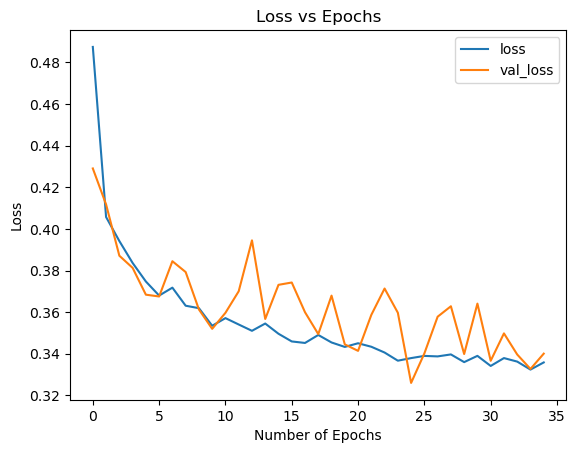

In [17]:
history[["loss", "val_loss"]].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig('LossVsEpochsMn.png')
plt.show()

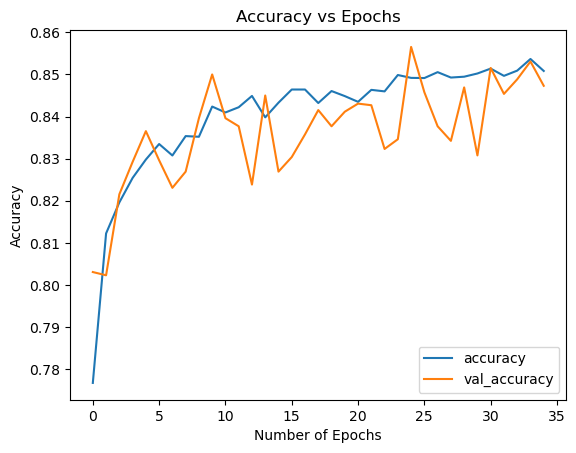

In [18]:
history[['accuracy', 'val_accuracy']].plot()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig('AccuracyvsEpochsMn.png')
plt.show()

In [19]:
predictions = mobilenet_model.predict(test_image_gen)

82/82 [==============================] - 19s 216ms/step


In [20]:
predictions = predictions >= 0.5

In [21]:
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1300
           1       0.84      0.86      0.85      1300

    accuracy                           0.85      2600
   macro avg       0.85      0.85      0.85      2600
weighted avg       0.85      0.85      0.85      2600



In [22]:
confusion_matrix(test_image_gen.classes, predictions)

array([[1083,  217],
       [ 178, 1122]], dtype=int64)

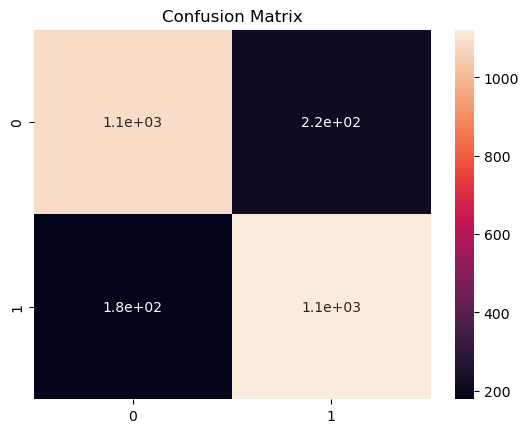

In [23]:
DetaFrame_cm = pd.DataFrame(confusion_matrix(test_image_gen.classes, predictions), range(2), range(2))
sns.heatmap(DetaFrame_cm, annot=True)
plt.title("Confusion Matrix")
plt.savefig('ConfusionMatrixHeatmapMn.png')
plt.show()

In [24]:
mobilenet_model.save("MalariaPredictionsMn.h5")